In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load data and engineer features
data = pd.read_csv('Ames_HousePrice.csv')
data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['YearsSinceRemodel'] = data['YrSold'] - data['YearRemodAdd']
data['TotalBath'] = data['FullBath'] + data['HalfBath'] + data['BsmtFullBath'] + data['BsmtHalfBath']
data['Porch'] = data['WoodDeckSF'] + data['OpenPorchSF'] + data['EnclosedPorch'] + data['3SsnPorch'] + data['ScreenPorch']
data.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)
target = 'SalePrice'

# Identify column types
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove(target)
categorical_features = data.select_dtypes(include=['object']).columns.tolist()


# Split the dataset
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Log-transform the target (if SalePrice is skewed)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Build preprocessing pipelines
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

# Example: Ridge regression with a pipeline
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

ridge_param_grid = {
    'model__alpha': [0.1, 1, 10, 100, 1000]
}

ridge_grid_search = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, scoring='r2', verbose=1)
ridge_grid_search.fit(X_train, y_train_log)

print("Ridge best parameters:", ridge_grid_search.best_params_)
print("Ridge best cross-validation score: {:.4f}".format(ridge_grid_search.best_score_))

# Evaluate on the test set (remember to convert predictions back from log-space)
y_pred_log = ridge_grid_search.predict(X_test)
y_pred = np.exp(y_pred_log)  # convert back to original scale
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Ridge Model -> R^2: {r2:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Ridge best parameters: {'model__alpha': 10}
Ridge best cross-validation score: 0.9149
Ridge Model -> R^2: 0.9330


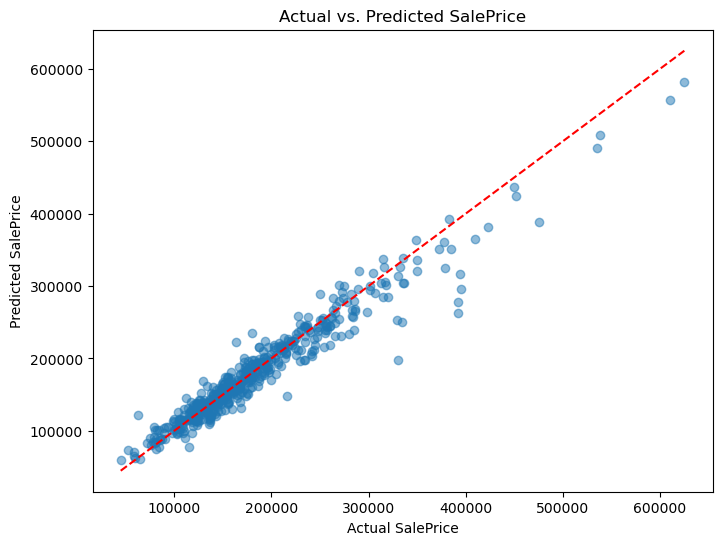

In [4]:
#Actual vs Predicted Sale Price: Most points align with the ideal prediction line, confirming a strong correlation
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs. Predicted SalePrice")
# Plot the ideal 45-degree line where predictions equal actual values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

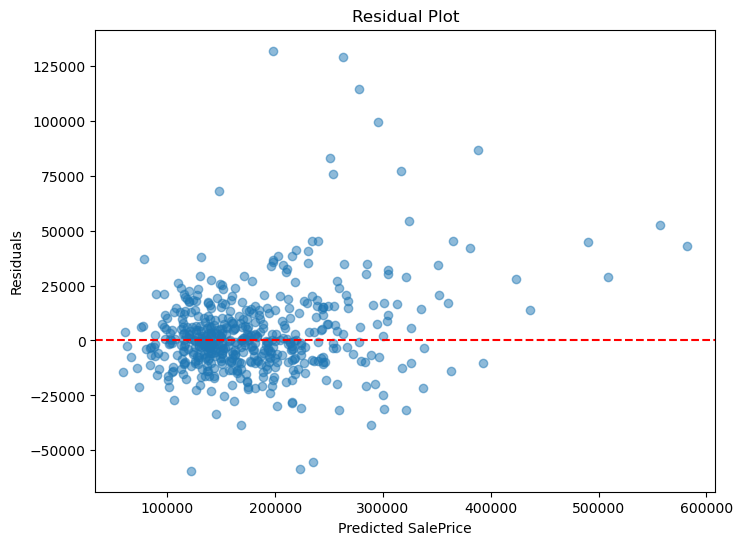

In [6]:
# Compute residuals: difference between actual and predicted sale prices
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(0, color='r', linestyle='--')  # Horizontal line at zero
plt.show()
